### Note:
- This notebook only process three types of experiment data which are:
1. EMG measurement from three channels
2. Elbow flexion / extension

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import scipy
from scipy import signal
from scipy.signal import freqz

import math

In [26]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
xa = np.asarray(x)
vara = (1 / (len(xa) - 1)) * np.sum([s ** 2 for s in xa])
print(vara)
a = 4
print(np.sqrt(a))

35.625
2.0


### Prepare the functions of filter

In [2]:
def full_wave_rectify(signal):
    rectify_emg = np.absolute(signal)
    return rectify_emg
    
def band_pass(signal, fs = 2000, high_band = 1000, low_band = 10, order = 4, padB = False, axs = -1, pad = 0):
    """
    signal: rectified EMG data
    high_band: high pass filter cut off frequency
    low_band: low pass filter cut off frequency
    fs: sampling frequency
    order: order of filter
    """
    # normalize cut-off frequency by sampling frequency
    high_band = high_band / (fs / 2)
    low_band = low_band / (fs / 2)
    # create bandpass filter gain
    b, a = scipy.signal.butter(order, [low_band, high_band], btype='bandpass')
    
    # Filter EMG 
    if padB:
        emg_bandpass = scipy.signal.filtfilt(b, a, signal, padlen = pad, axis = axs)
    else:
        emg_bandpass = scipy.signal.filtfilt(b, a, signal, axis = axs)
    return emg_bandpass

def low_pass(signal, fs = 2000, low_pass = 10, order = 4, axs = -1, padB = False, pad = 0):
    """
    signal: rectified EMG data
    low_pass: low pass filter cut off frequency
    fs: sampling frequency
    order: rder of filter
    """
    
    # normalize cut-off frequency
    low_pass = low_pass / (fs / 2)
    #create lowpass filter
    b, a = scipy.signal.butter(order, low_pass, btype = 'lowpass')
    
    if padB:
        emg_envelop = scipy.signal.filtfilt(b, a, signal, padlen = pad, axis = axs )
    else:
        emg_envelop = scipy.signal.filtfilt(b, a, signal, axis = axs)
        
    return emg_envelop

def high_pass(signal, fs = 2000, high_pass = 10, order = 4, axs = -1, padB = False, pad = 0):
    """
    signal: rectified EMG data
    high_pass: high pass filter cut off frequency
    fs: sampling frequency
    order: order of filter
    """
    
    high_pass = high_pass / (fs / 2)
    b, a = scipy.signal.butter(order, high_pass, btype = 'highpass')
    if padB:
        emg_envelop = scipy.signal.filtfilt(b, a, signal, padlen = pad, axis = axs)
    else:
        emg_envelop = scipy.signal.filtfilt(b, a, signal, axis = axs)
    return emg_envelop
    

### Prepare feature extraction functions

In [3]:
a = np.arange(10, 5831, 10)
j = 0
for i in range(len(a)):
    j += 1
print(j)

583


In [4]:
def getEMGfeatures(emg, window = 1, step = 1):
    """
    emg: filtered rectified EMG signal
    window: size of sliding windows
    step: number of step between two windows
    """
    endPt = len(emg)
    pts = np.arange(window, endPt, step)
    j = 0
    for i in range(len(pts)):
        j += 1
        sampleEMG = emg[pts[i] - window + 1:pts[i], :]
        pass
        
    
def getfeaturesTD(emg):
    pass
    

### Data Preprocessing
1. Full-wave rectification
2. Remove the noise from data by using Butterworth Filter
3. Feature extraction
4. Dimensionality Reduction (*Optional)
5. Save the data as '.csv' file

In [5]:
# Setup the parameters of signal
f = 2000

In [6]:
path = r'/home/jerry/GitHub/EMG_regressive_model/data_process/raw_data'
# path = r'D:/GitHub/EMG_regressive_model/data_process/raw_data'
all_files = glob.glob(path+'/*.csv')
dfList = []

In [7]:
# Read .csv file by using panda
# for filename in all_files:
file = all_files[0]
saveName = file[-11:-4]
print(file)
allData = pd.read_csv(file, skiprows = 4, header = None)


/home/jerry/GitHub/EMG_regressive_model/data_process/raw_data/2021-06-08-13-27_CUBE elbow data collection_4.4_T_2.csv


/home/jerry/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
# Create the dataframe for EMG data and Joint angle
emgData = allData.iloc[:, 3:6]
angleData = allData.iloc[:, 32:33]

#Convert the dataframe to numpy array
emg = emgData.to_numpy()
time = np.array([i/f for i in range(0, len(emg), 1)]) # sampling rate 2000 Hz
mean = np.mean(emg, axis = 0)
emgAvg = emg - mean

angle = angleData.to_numpy()
# Perform the full wave rectification
rectEmg = full_wave_rectify(emgAvg)
print(rectEmg.shape[-1] - 1)
bpEmg = band_pass(rectEmg, fs = f, high_band = 200, low_band = 10, order = 6, padB = True, axs = -1, pad = 0)
features = getEMGfeatures(bpEmg, window = 10, step = 10)
# print(len(angle))
# print(len(bpEmg))
# print(angle.shape[0] - 1)
bpAngle = band_pass(angle, fs = f, high_band = 100, low_band = 10, order = 4, axs = -1, padB = True, pad = 0)


2
61720
61720
61719


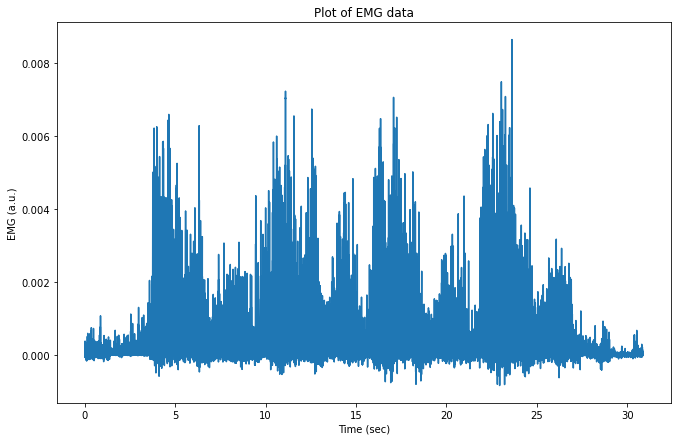

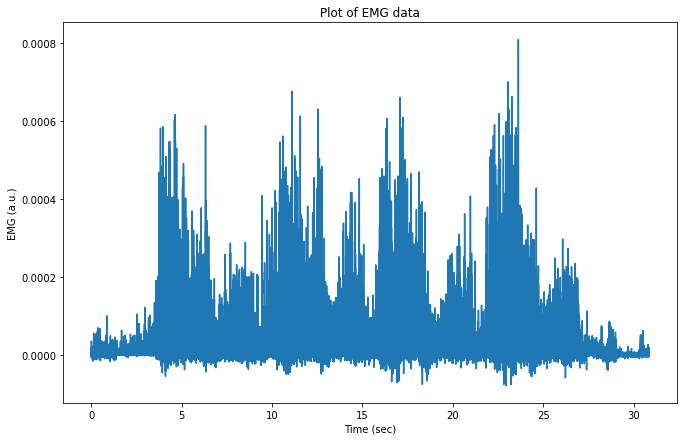

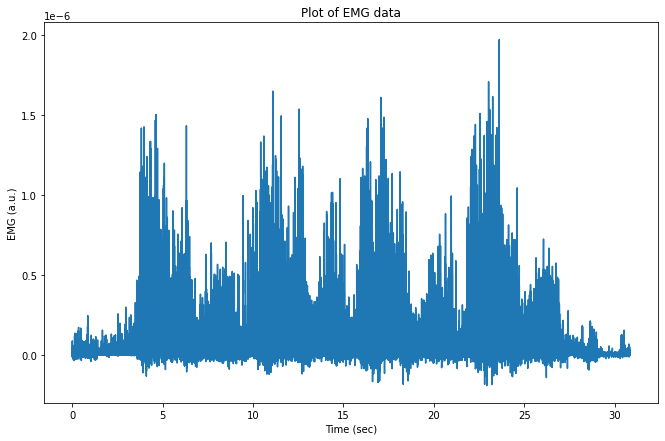

In [15]:
for i in range(3):
    fig = plt.figure()
    plt.plot(time, bpEmg[:, i])
    plt.xlabel('Time (sec)')
    plt.ylabel('EMG (a.u.)')
    plt.title('Plot of EMG data')
    fig_name = 'Filt'+str(i)+'.png'
    fig.set_size_inches(w=11,h=7)
    fig.savefig(fig_name)